Time Series Regression using Air Passengers Data

**About the Project**<br>
This Project entails analysis of Air Passengers Time Series data and making predictions for future time periods. Firstly, I have done some visual explorations of the data to understand the time series which reveals that this time series is not stationary. I have then exploited several techniques like moving average smoothing, differencing and decomposition to convert non-stationary time series into close to stationary so that it can be used for further modeling.

I have then applied ARIMA modeling to make predictions for in-sample and out-of-sample data

**About the Dataset**<br>
The number of international passengers per month on an airline in US were obtained from the Fedral Aviation Administration for the period 1946-1960. The company used the data to predict future demand before ordering new aircraft and training aircrew. The data are available as a time series and is named AirPassengers

In [113]:
#importing required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.arima_model import ARIMA
import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [114]:
#setting the current working directory to csv file location
os.chdir('D:\Data Science\Projects\Time Series Regression')

In [115]:
#loading data
data = pd.read_csv('AirPassengers.csv')
print data.head()

#checking data types
print '\n Data Types:'
print data.dtypes

#note that Month column is of datatype object

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [116]:
#in order to comvert this into timeseries data, we need to convert Month column into datetime type and make this an index column
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [117]:
#check that Month is now a datetime index column
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

In [118]:
ts=data["#Passengers"]

In [10]:
#OR you can try this to convert Month column into datetime index column
#data = pd.read_csv('AirPassengers.csv')
#data.Month=pd.to_datetime(data.Month, errors='coerce')
#data.set_index('Month', inplace=True)

In [11]:
#indexing 
print ts['1949-01-01':'1949-05-01']
print ts[:'1949-05-01']
#both yield same results
#note that end index is included here, unlike numeric indexing

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


**Checking the Stationarity of a Time Series**

A time series is said to be **stationary** if it has-<br>
1.**constant mean** over time<br>
2.**constant variance** over time<br>
3.an **autocovariance that is time independent**

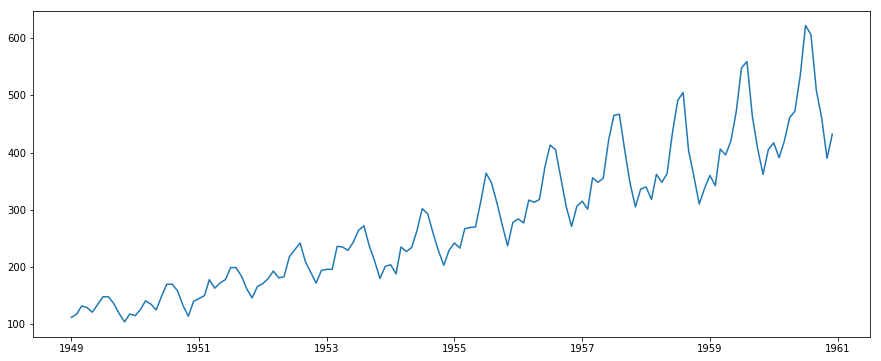

In [213]:
plt.plot(ts)
#notice the overall increasing trend in the timeseries with some seasonal variations

The below function checks the stationarity of a time series by employing-
1. **Rolling Statistics** - plot moving average/variance to see if it varies with time
2. **Dickey-fuller test** - Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

In [119]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()    

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

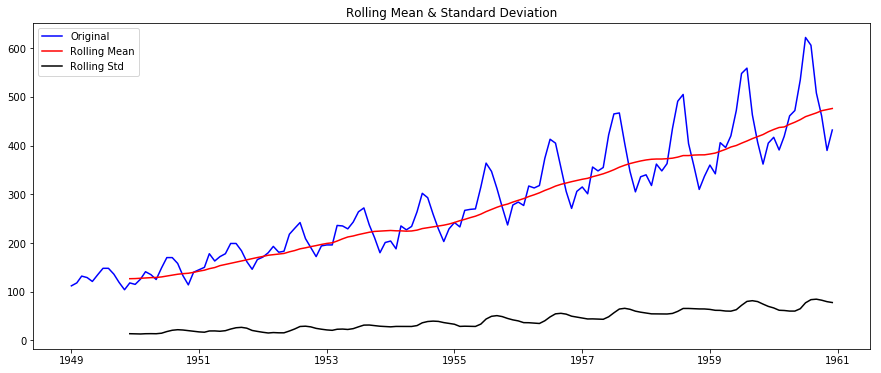

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [75]:
test_stationarity(ts)

#Note that mean is increasing with time, although variation is standard deviation is small
#Dickey fuller test statistic is more than the critical value- hence the series is non-stationary

Stabilizing variance with **log transformation**

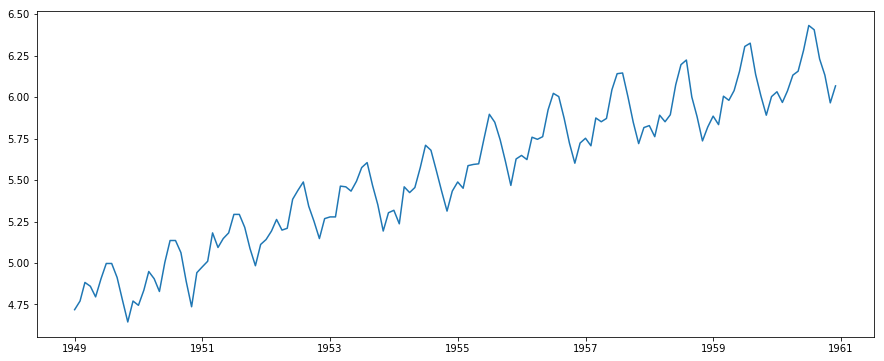

In [120]:
ts_log = np.log(ts)
plt.plot(ts_log)
#notice that the relationship is now more linear and variance has stabilized

Eliminating Trend from Time Series 

Smoothing (taking rolling averages and differencing) to eliminate trend

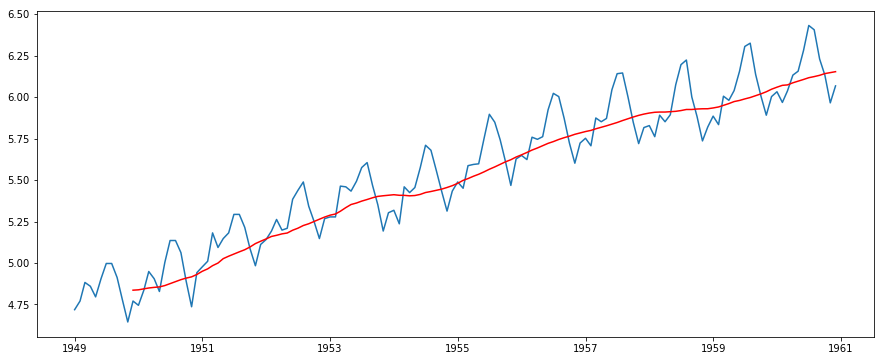

In [121]:
moving_avg = ts_log.rolling(window=12,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [122]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

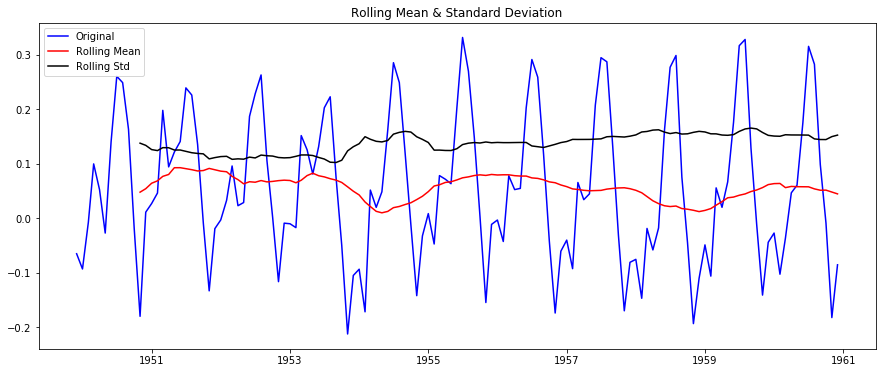

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [123]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. 
#Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series

**Exponentially Weighted Moving Average Smoothing** - for example in case of stock prices movement it is difficult to take rolling averages
and come up with a number, as time period cannot be strictly defined ( like in this case - year). So we take a ‘weighted moving average’ where more recent values are given a higher weight. In this technique, weights are assigned to all the previous values with a decay factor

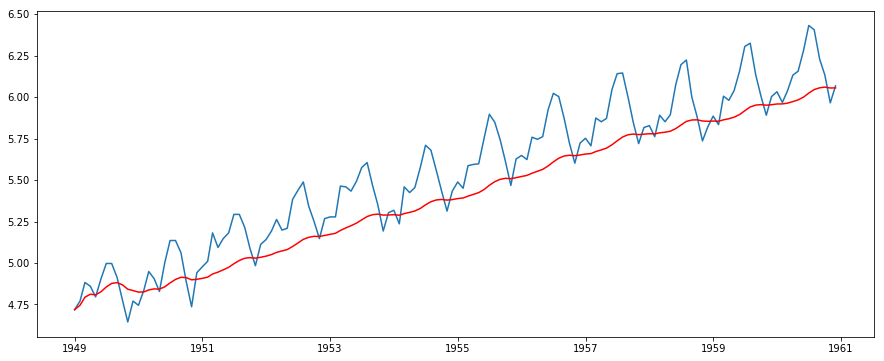

In [82]:
expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

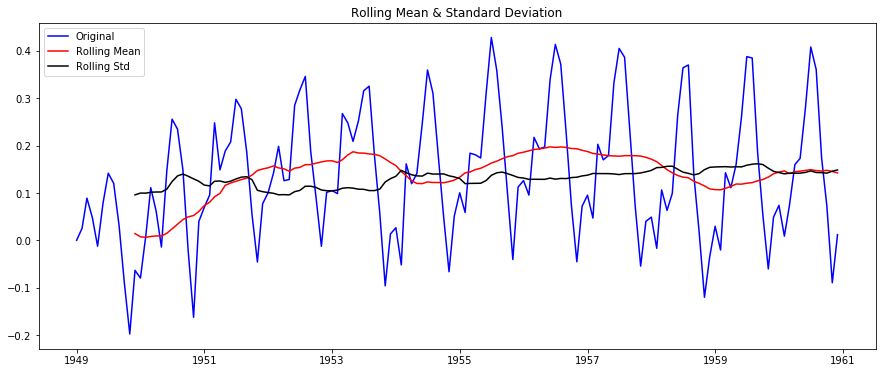

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [83]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

#This TS has even lesser variations in mean and standard deviation in magnitude. 
#Also, the test statistic is smaller than the 1% critical value, which is better than the previous case

Other powerful techniques to eliminate trend and seasonality

Differencing - with a particular time shift

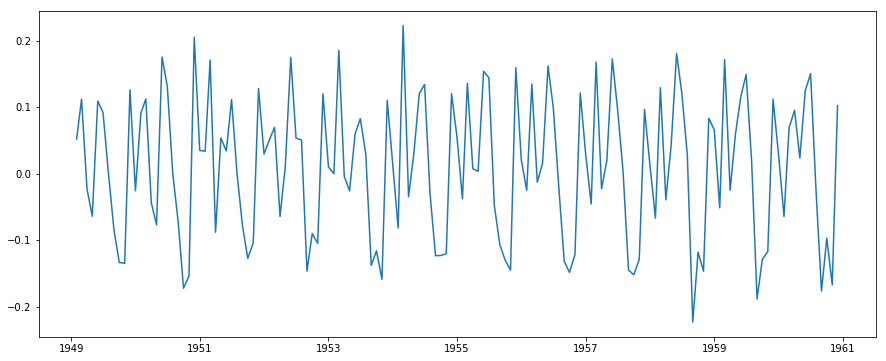

In [215]:
#First order differencing to eliminate trend
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

#We can further take 12th differnce of first difference to eliminate annual cycles (not considered in this post)

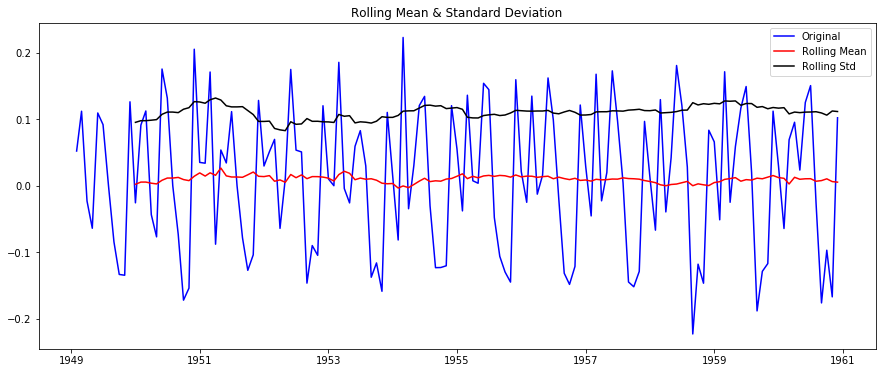

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [128]:
#Here is a plot of the 1st difference of the log to eliminate the linear trend
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#We can see that the mean and std variations have small variations with time. 
#Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence

Decompose time series into trend, seasonal and residual components

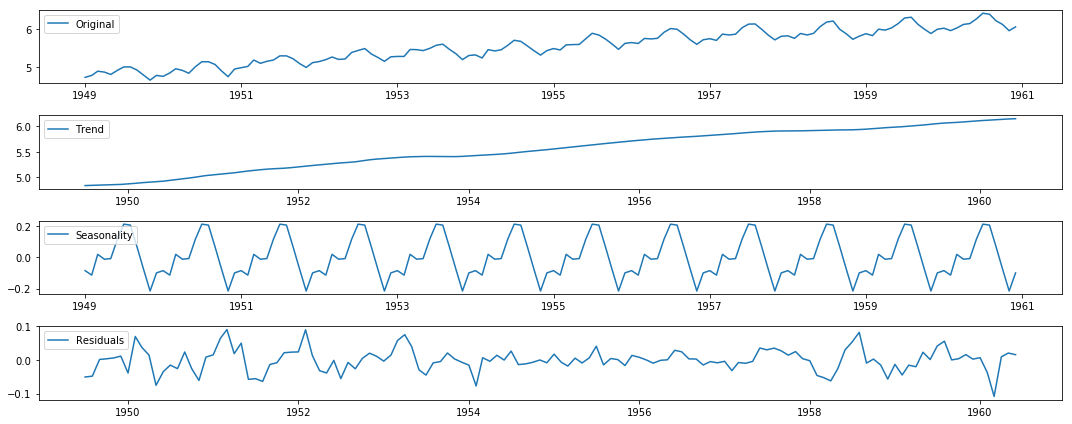

In [125]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

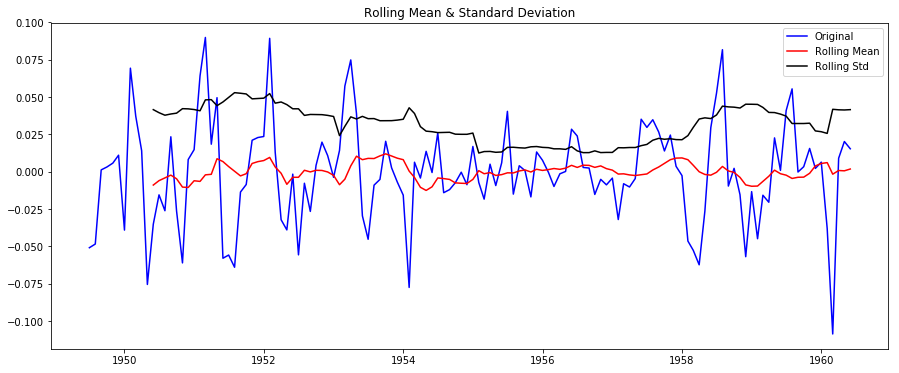

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [126]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)
#The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

Forecasting a Time Series using ARIMA model

The predictors depend on the parameters (p,d,q) of the ARIMA model, where p is number of auto-regressive terms, q is number of moving average terms and d is number of non-seasonal differences. We can find p and q using ACF and PACF plots

We will use the first difference of log of time series here as that's a very popular technique

In [129]:
#ACF and PACF plots to determine model parameters-
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

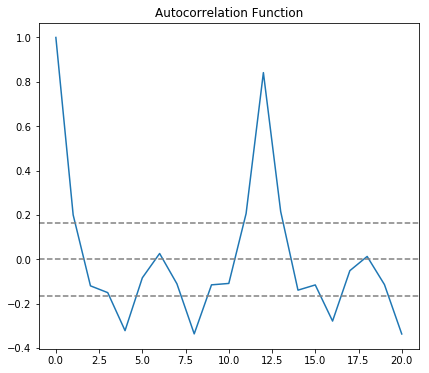

In [130]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#q – The lag value where the ACF chart crosses the upper confidence interval for the first time; q=2

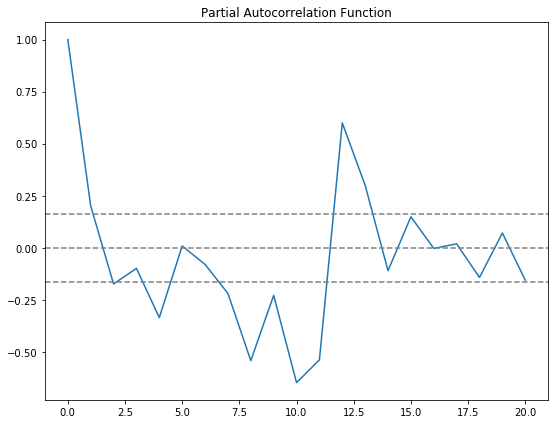

In [131]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#p – The lag value where the PACF chart crosses the upper confidence interval for the first time; p=2

AR Model

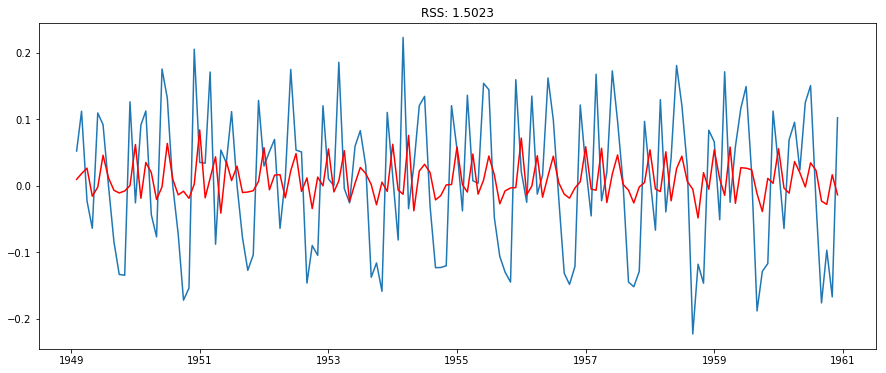

In [132]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

MA Model

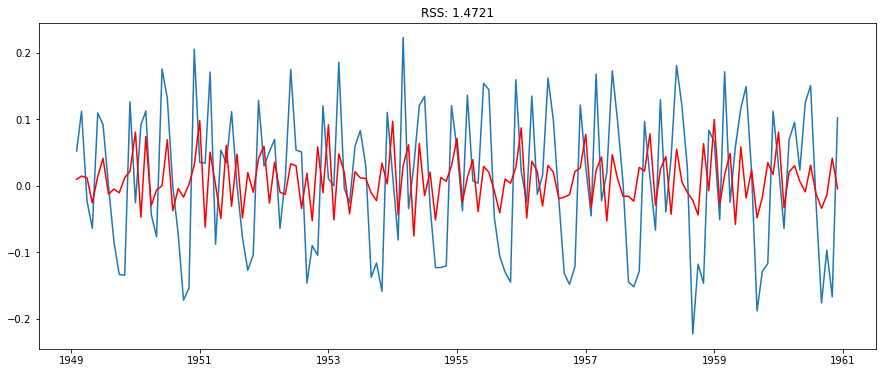

In [25]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

ARIMA Model

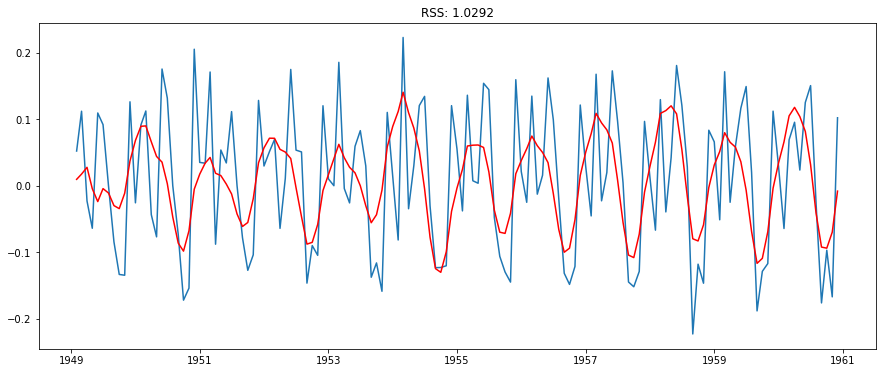

In [133]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

#Notice that ARIMA model has significantly lower RSS than AR or MA models

In [149]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
dtype: float64


In [165]:
#Above predictions are predictions of the differences which need to be taken back to the original scale by taking the 
#cumulative sum and then adding these to the base value

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [136]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

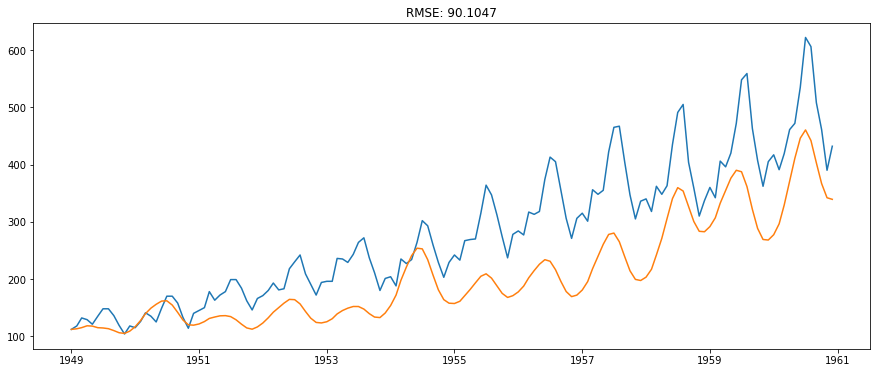

In [34]:
#Next step is to take the exponent and compare with the original series
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Foreceasting for out-of-sample data

In [137]:
#In order to generate future forecasts, I first add the new time periods to the dataframe
start = datetime.datetime.strptime("1961-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list)
ts = pd.concat([ts, future])

#print ts (check to see the new time periods added to the time series for which we shall forceast the passengers)

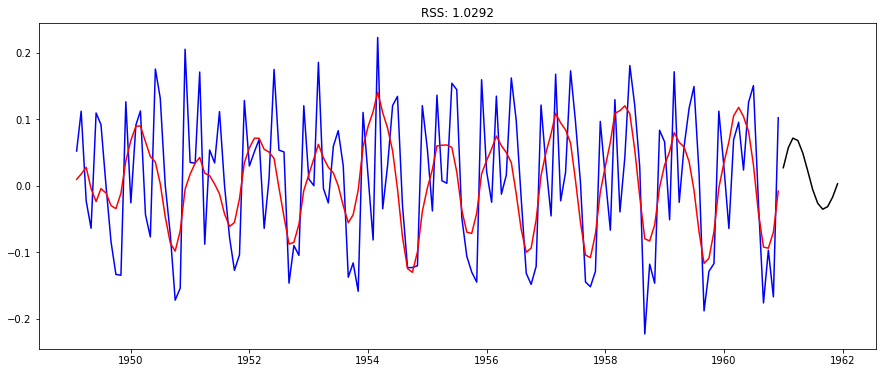

In [187]:
ts_forecast = results_ARIMA.predict(start ='1961-01-01', end = '1961-12-01') 
plt.plot(ts_log_diff, color='blue')
plt.plot(ts_forecast, color='black')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [202]:
cumsum=predictions_ARIMA_diff_cumsum[142]
forecast_cumsum = cumsum + ts_forecast.cumsum()

In [203]:
base=ts_log.ix[0]
forecast_log = forecast_cumsum+base

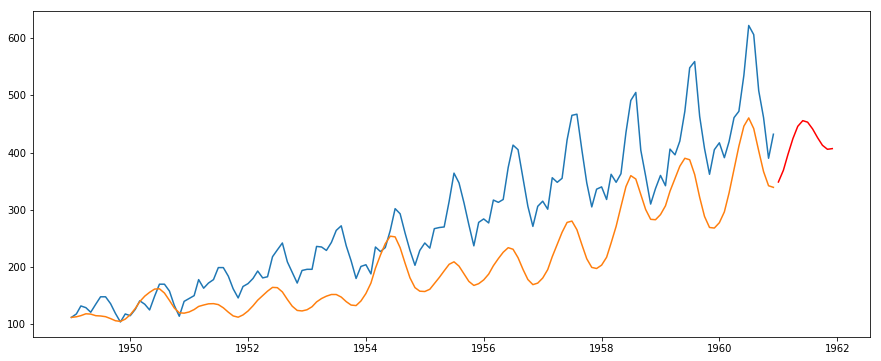

In [214]:
forecast = np.exp(forecast_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.plot(forecast,color='red')

#Notice the forecast for out-of-sample data in red

References: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ 